<a href="https://colab.research.google.com/github/nhyunaa/2025-1_CV/blob/main/CV_HW3_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#실험A


[실험] 손실 함수: CrossEntropyLoss
Epoch 01 | Train Loss: 0.4903, Train Acc: 0.8204 | Test Loss: 0.4369, Test Acc: 0.8432
Epoch 02 | Train Loss: 0.3688, Train Acc: 0.8646 | Test Loss: 0.3871, Test Acc: 0.8581
Epoch 03 | Train Loss: 0.3278, Train Acc: 0.8792 | Test Loss: 0.3697, Test Acc: 0.8660
Epoch 04 | Train Loss: 0.3045, Train Acc: 0.8872 | Test Loss: 0.3839, Test Acc: 0.8603
Epoch 05 | Train Loss: 0.2869, Train Acc: 0.8934 | Test Loss: 0.3469, Test Acc: 0.8755
Epoch 06 | Train Loss: 0.2709, Train Acc: 0.8990 | Test Loss: 0.3632, Test Acc: 0.8734
Epoch 07 | Train Loss: 0.2584, Train Acc: 0.9035 | Test Loss: 0.3444, Test Acc: 0.8799
Epoch 08 | Train Loss: 0.2460, Train Acc: 0.9069 | Test Loss: 0.3298, Test Acc: 0.8830
Epoch 09 | Train Loss: 0.2330, Train Acc: 0.9116 | Test Loss: 0.3412, Test Acc: 0.8799
Epoch 10 | Train Loss: 0.2207, Train Acc: 0.9170 | Test Loss: 0.3402, Test Acc: 0.8823
Epoch 11 | Train Loss: 0.2131, Train Acc: 0.9191 | Test Loss: 0.3414, Test Acc: 0.8857
Epoch 12 | Tr

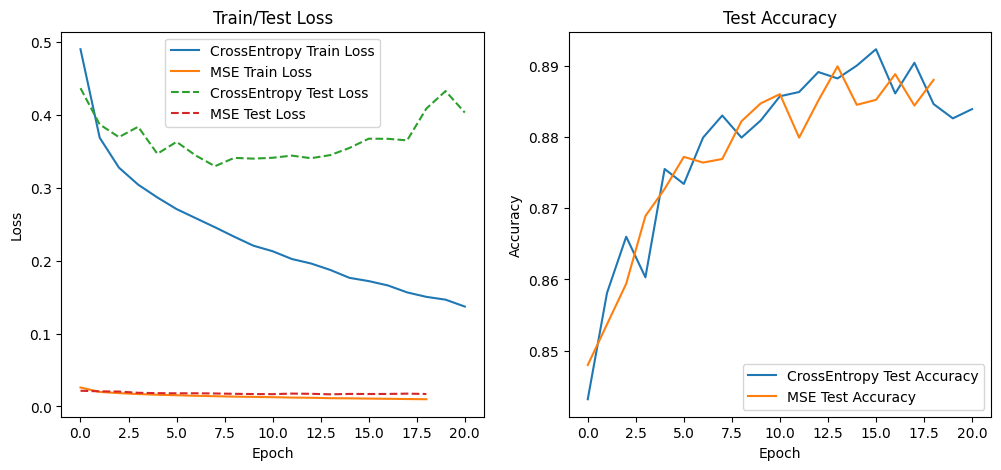

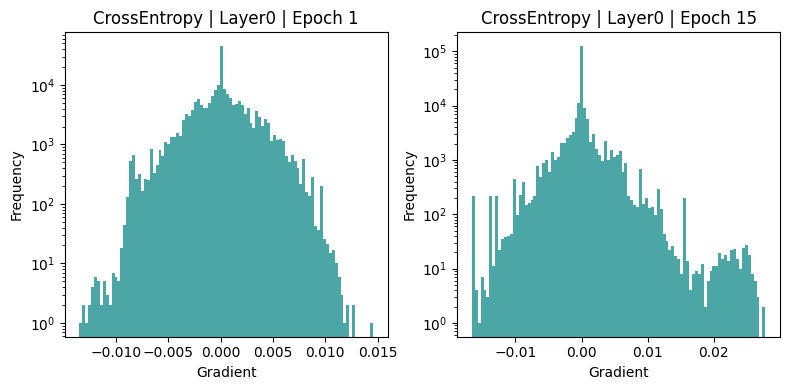

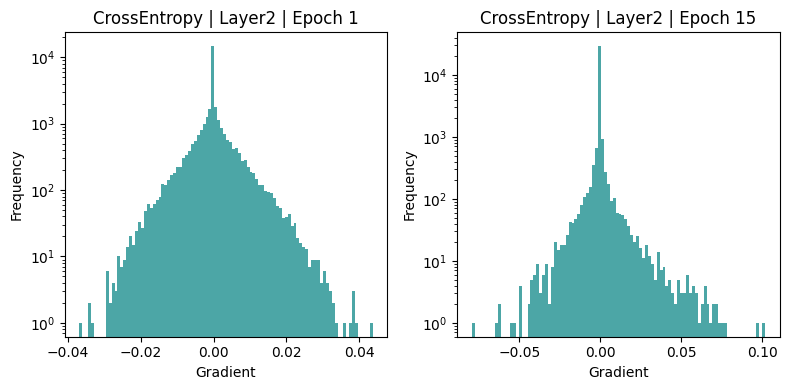

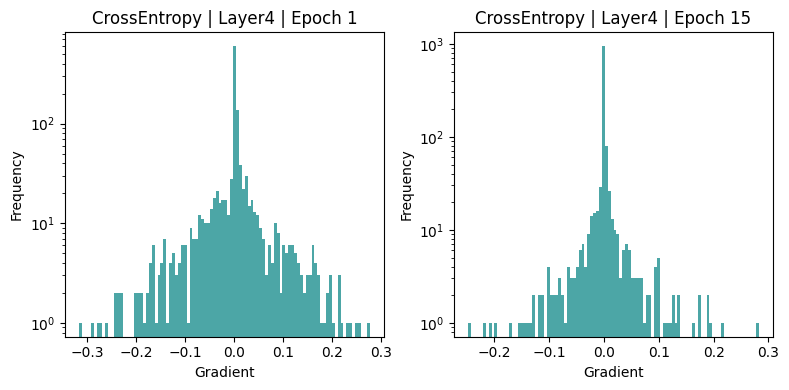

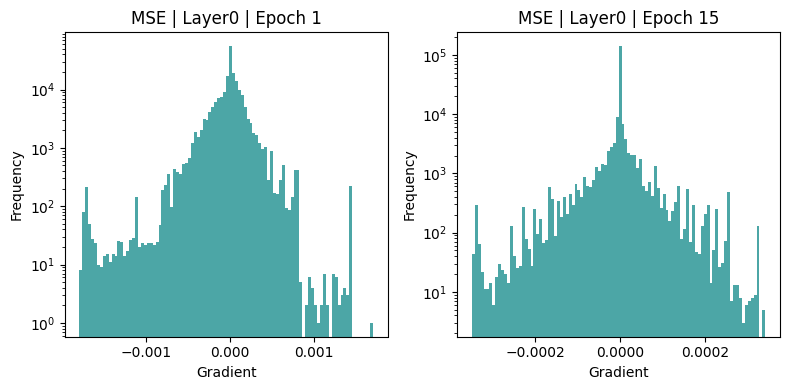

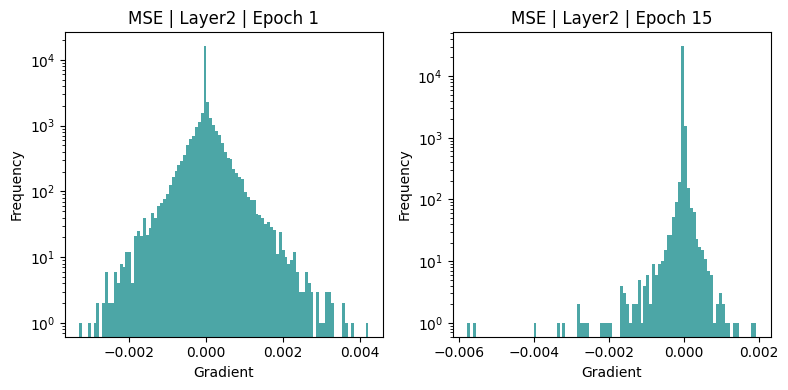

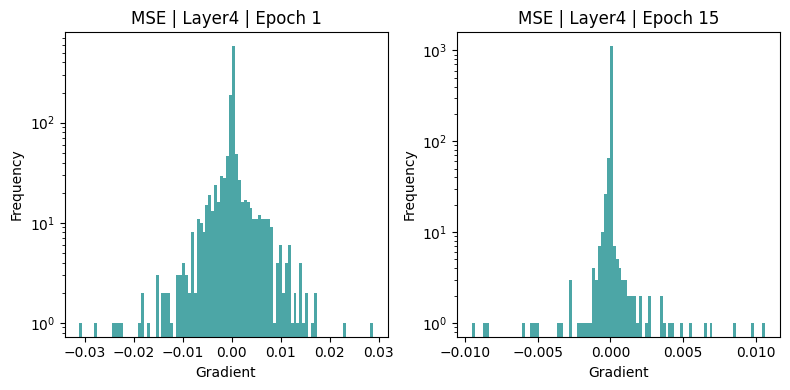

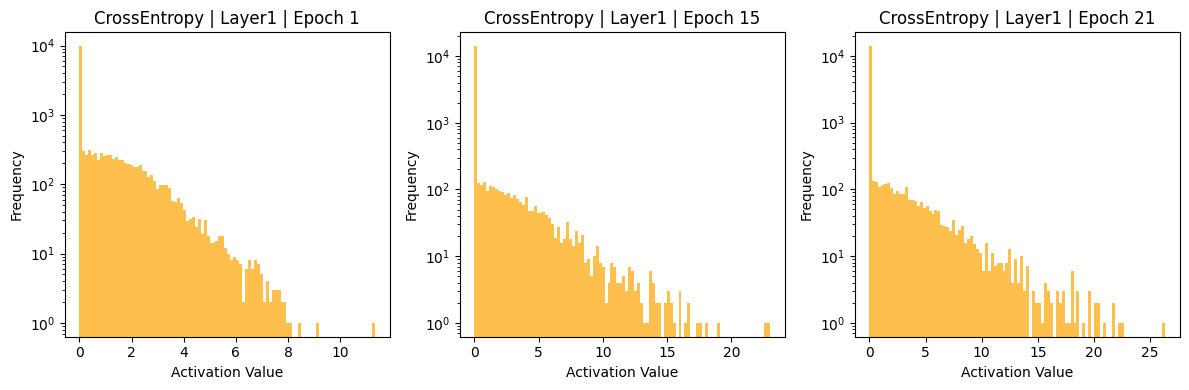

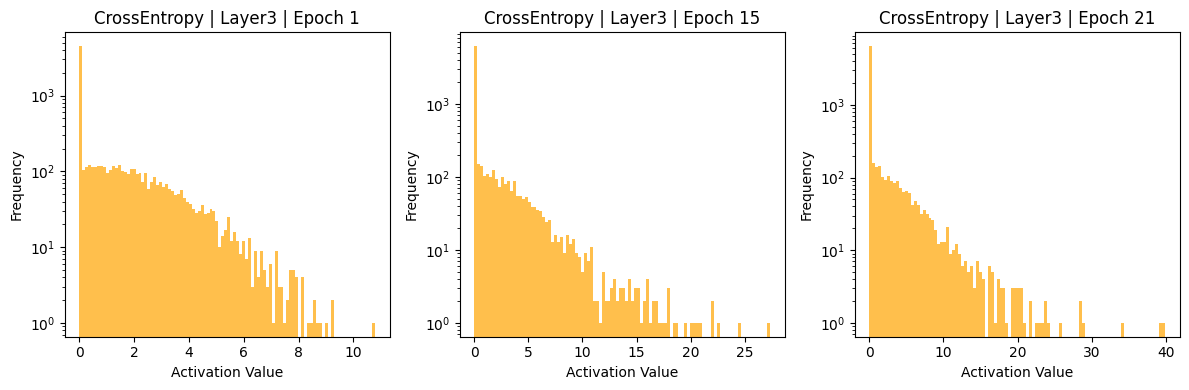

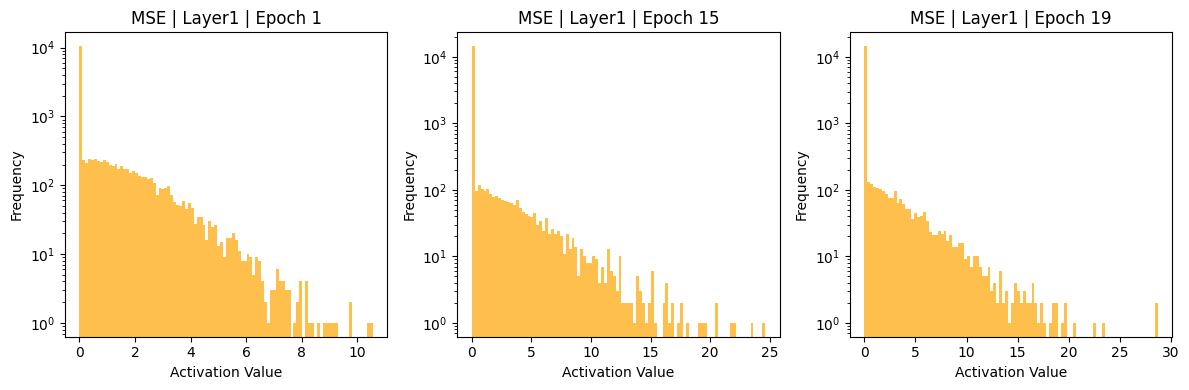

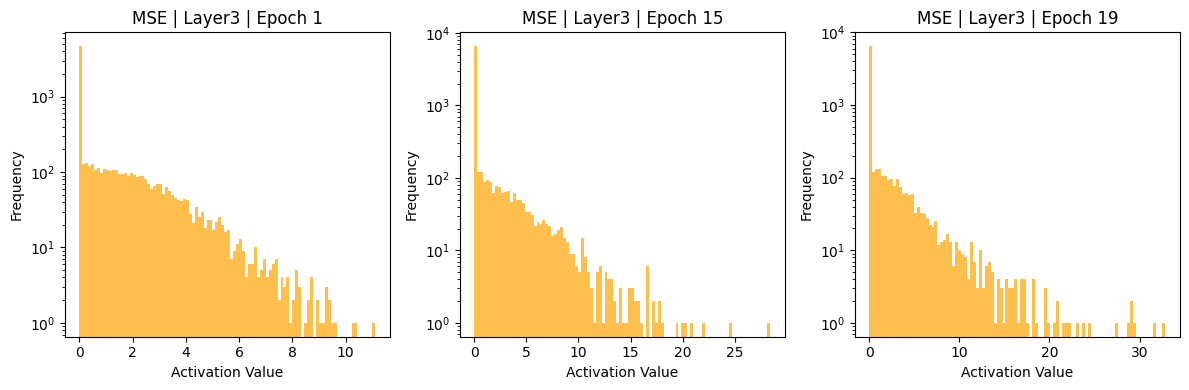

In [10]:
# 필요한 라이브러리 import
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

# seed 고정 함수 정의 (재현성 확보용)
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# seed 설정(같은결과나오도록)
set_seed(42)

# 학습 epoch 수 설정
EPOCHS = 30

# 데이터 전처리 (정규화 포함) 및 데이터셋 준비
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 학습에 사용할 디바이스 설정 (GPU 사용 가능 시 CUDA 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 다층 퍼셉트론(MLP) 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),  # 입력층 → 은닉층1
            nn.ReLU(),
            nn.Linear(256, 128),    # 은닉층1 → 은닉층2
            nn.ReLU(),
            nn.Linear(128, 10)      # 은닉층2 → 출력층
        )
        self.activations = {}  # 활성화 값 저장용 딕셔너리

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 이미지(28x28)를 1D 벡터로 변환
        for i, layer in enumerate(self.model):
            x = layer(x)
            if isinstance(layer, (nn.ReLU, nn.Sigmoid)):  # ReLU 또는 Sigmoid 레이어의 출력값 저장
                self.activations[f'Layer{i}'] = x.detach().cpu().numpy()
        return x

# 학습 함수
def train(model, device, train_loader, optimizer, loss_fn, epoch=None, grad_dict=None, total_epochs=None):
    model.train()
    total_loss = 0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 28*28)

        optimizer.zero_grad()
        output = model(data)

        # 손실 함수가 MSE인 경우 One-hot encoding 및 softmax 처리 필요
        if isinstance(loss_fn, nn.MSELoss):
            output = torch.softmax(output, dim=1)
            target_onehot = nn.functional.one_hot(target, num_classes=10).float()
            loss = loss_fn(output, target_onehot)
        else:
            loss = loss_fn(output, target)

        loss.backward()

        # 특정 epoch마다 gradient 저장
        if grad_dict is not None:
            if epoch in [1, total_epochs // 2, total_epochs]:
                grad_dict.setdefault(epoch, {})
                for i, layer in enumerate(model.model):
                    grads = []
                    if hasattr(layer, 'weight') and layer.weight is not None and layer.weight.grad is not None:
                        grads.append(layer.weight.grad.view(-1))
                    if hasattr(layer, 'bias') and layer.bias is not None and layer.bias.grad is not None:
                        grads.append(layer.bias.grad.view(-1))
                    if grads:
                        grad_dict[epoch][f'Layer{i}'] = torch.cat(grads).detach().cpu().numpy()

        optimizer.step()

        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# 평가 함수 (검증 데이터에서 성능 확인용)
def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            output = model(data)

            if isinstance(loss_fn, nn.MSELoss):
                output = torch.softmax(output, dim=1)
                target_onehot = nn.functional.one_hot(target, num_classes=10).float()
                loss = loss_fn(output, target_onehot)
            else:
                loss = loss_fn(output, target)

            test_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# 전체 실험 실행 함수
def run_experiment(loss_fn_name, patience=5, epochs=EPOCHS):
    model = MLP().to(device)
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

    print(f"\n[실험] 손실 함수: {loss_fn_name}")

    loss_fn = nn.CrossEntropyLoss() if loss_fn_name == "CrossEntropyLoss" else nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    grad_distributions = {}
    activation_snapshots = {}

    best_acc = 0
    patience_counter = 0
    final_epoch = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_loader, optimizer, loss_fn,
                                      epoch=epoch, grad_dict=grad_distributions, total_epochs=epochs)
        test_loss, test_acc = test(model, device, test_loader, loss_fn)

        # 활성화 분포 저장 (초반, 중반, 마지막 시점 기준)
        if epoch in [1, epochs // 2] or patience_counter == patience - 1:
            sample_data, _ = next(iter(train_loader))
            sample_data = sample_data.to(device)
            model(sample_data)
            activation_snapshots[epoch] = {k: v.flatten() for k, v in model.activations.items()}

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        final_epoch = epoch
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Early stopping 조건 체크
        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    # 마지막 epoch에 대한 activation 저장
    if final_epoch not in activation_snapshots:
        sample_data, _ = next(iter(train_loader))
        sample_data = sample_data.to(device)
        model(sample_data)
        activation_snapshots[final_epoch] = {k: v.flatten() for k, v in model.activations.items()}

    return train_losses, train_accuracies, test_losses, test_accuracies, grad_distributions, activation_snapshots, final_epoch, model

# 두 가지 손실 함수(CrossEntropy, MSE)에 대한 실험 실행
cross_train_losses, cross_train_acc, cross_test_losses, cross_test_acc, cross_grads, cross_acts, cross_final_epoch, cross_model = run_experiment("CrossEntropyLoss")
mse_train_losses, mse_train_acc, mse_test_losses, mse_test_acc, mse_grads, mse_acts, mse_final_epoch, mse_model = run_experiment("MSELoss")

# 저장된 epoch 중 가장 가까운 값 찾는 함수
def closest_epoch(target, epoch_list):
    return min(epoch_list, key=lambda x: abs(x - target))

# CrossEntropy에서 시각화에 사용할 epoch 추출
cross_act_epochs = sorted(cross_acts.keys())
cross_epochs_to_plot = sorted(set([
    closest_epoch(1, cross_act_epochs),
    closest_epoch(cross_final_epoch // 2, cross_act_epochs),
    closest_epoch(cross_final_epoch, cross_act_epochs)
]))

# MSE에서 시각화에 사용할 epoch 추출
mse_act_epochs = sorted(mse_acts.keys())
mse_epochs_to_plot = sorted(set([
    closest_epoch(1, mse_act_epochs),
    closest_epoch(mse_final_epoch // 2, mse_act_epochs),
    closest_epoch(mse_final_epoch, mse_act_epochs)
]))

# Gradient 분포 시각화 함수
def plot_gradients(grad_dict, title_prefix=""):
    all_epochs = sorted(grad_dict.keys())
    all_layers = sorted({name for epoch_dict in grad_dict.values() for name in epoch_dict})

    for layer_name in all_layers:
        plt.figure(figsize=(4 * len(all_epochs), 4))
        for i, epoch in enumerate(all_epochs):
            if layer_name not in grad_dict[epoch]:
                continue
            plt.subplot(1, len(all_epochs), i+1)
            plt.hist(grad_dict[epoch][layer_name], bins=100, alpha=0.7, color='teal', log=True)
            plt.title(f"{title_prefix} | {layer_name} | Epoch {epoch}")
            plt.xlabel("Gradient")
            plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# 활성화 분포 시각화 함수
def plot_activations(act_snapshots, title_prefix="", epochs=None):
    if epochs is None:
        epochs = sorted(act_snapshots.keys())
    for layer_name in act_snapshots[epochs[0]].keys():
        plt.figure(figsize=(4 * len(epochs), 4))
        for i, epoch in enumerate(epochs):
            plt.subplot(1, len(epochs), i + 1)
            activations = act_snapshots[epoch][layer_name]
            plt.hist(activations, bins=100, color='orange', alpha=0.7, log=True)
            plt.title(f"{title_prefix} | {layer_name} | Epoch {epoch}")
            plt.xlabel("Activation Value")
            plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# 손실 및 정확도 시각화
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(cross_train_losses, label='CrossEntropy Train Loss')
plt.plot(mse_train_losses, label='MSE Train Loss')
plt.plot(cross_test_losses, label='CrossEntropy Test Loss', linestyle='--')
plt.plot(mse_test_losses, label='MSE Test Loss', linestyle='--')
plt.title('Train/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cross_test_acc, label='CrossEntropy Test Accuracy')
plt.plot(mse_test_acc, label='MSE Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gradient 시각화 실행
plot_gradients(cross_grads, "CrossEntropy")
plot_gradients(mse_grads, "MSE")

# Activation 시각화 실행
plot_activations(cross_acts, "CrossEntropy", epochs=cross_epochs_to_plot)
plot_activations(mse_acts, "MSE", epochs=mse_epochs_to_plot)

# 로짓 분포 시각화 함수
def plot_logits_distribution(model, data_loader, title_prefix=""):
    model.eval()
    logits_all = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device).view(-1, 28*28)
            logits = model(data)
            logits_all.append(logits.cpu().numpy())
    logits_all = np.concatenate(logits_all).flatten()

    plt.figure(figsize=(6, 4))
    plt.hist(logits_all, bins=100, color='skyblue', alpha=0.7, log=True)
    plt.title(f"{title_prefix} Logit Value Distribution")
    plt.xlabel("Logit Value")
    plt.ylabel("Frequency (log scale)")
    plt.tight_layout()
    plt.show()


#실험 B

Using device: cuda

==== ReLU 활성화 함수 실험 ====
Epoch 01 | Train Loss: 0.6931, Train Acc: 0.5050 | Test Loss: 0.6931, Test Acc: 0.4883
Epoch 02 | Train Loss: 0.6927, Train Acc: 0.5050 | Test Loss: 0.6919, Test Acc: 0.4883
Epoch 03 | Train Loss: 0.6913, Train Acc: 0.5050 | Test Loss: 0.6884, Test Acc: 0.4883
Epoch 04 | Train Loss: 0.6878, Train Acc: 0.5050 | Test Loss: 0.6822, Test Acc: 0.5400
Epoch 05 | Train Loss: 0.6818, Train Acc: 0.5629 | Test Loss: 0.6726, Test Acc: 0.8450
Epoch 06 | Train Loss: 0.6725, Train Acc: 0.8350 | Test Loss: 0.6588, Test Acc: 0.8717
Epoch 07 | Train Loss: 0.6591, Train Acc: 0.8386 | Test Loss: 0.6401, Test Acc: 0.8733
Epoch 08 | Train Loss: 0.6408, Train Acc: 0.8414 | Test Loss: 0.6159, Test Acc: 0.8733
Epoch 09 | Train Loss: 0.6170, Train Acc: 0.8393 | Test Loss: 0.5858, Test Acc: 0.8733
Epoch 10 | Train Loss: 0.5875, Train Acc: 0.8393 | Test Loss: 0.5505, Test Acc: 0.8733
Epoch 11 | Train Loss: 0.5528, Train Acc: 0.8393 | Test Loss: 0.5114, Test Acc: 0.873

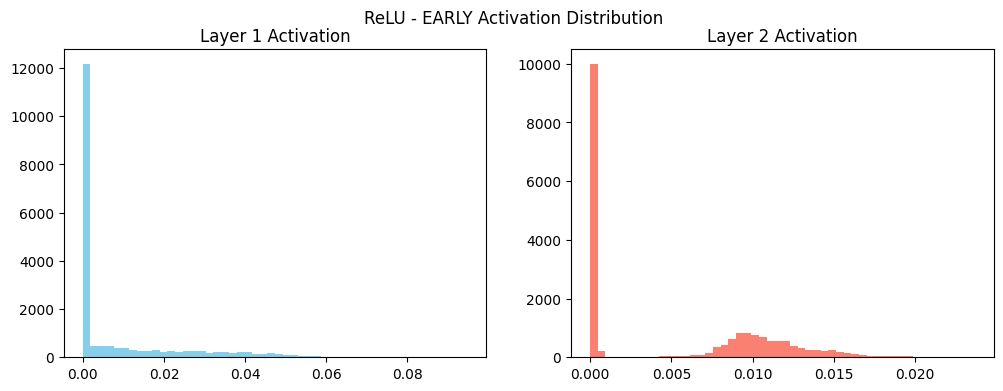

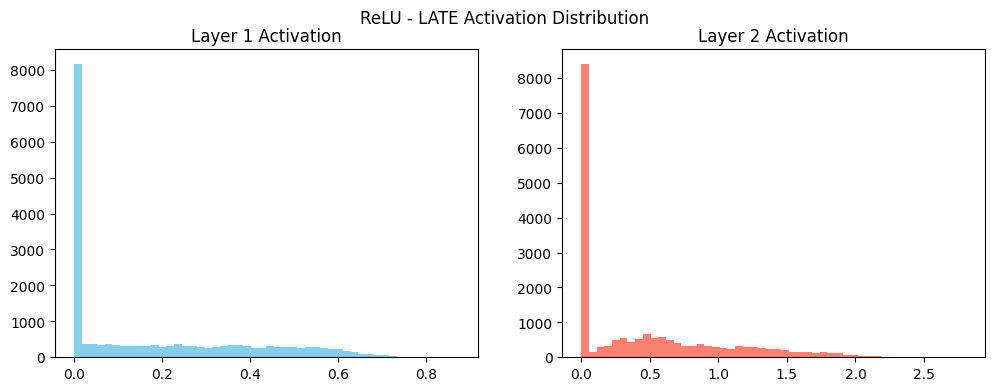

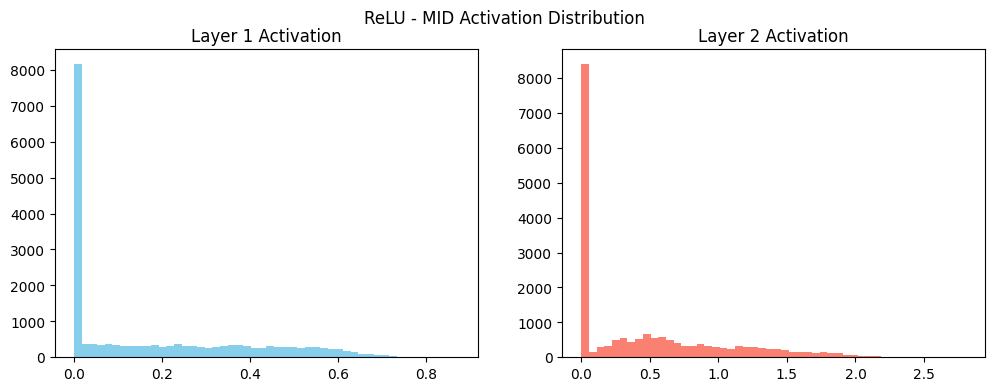

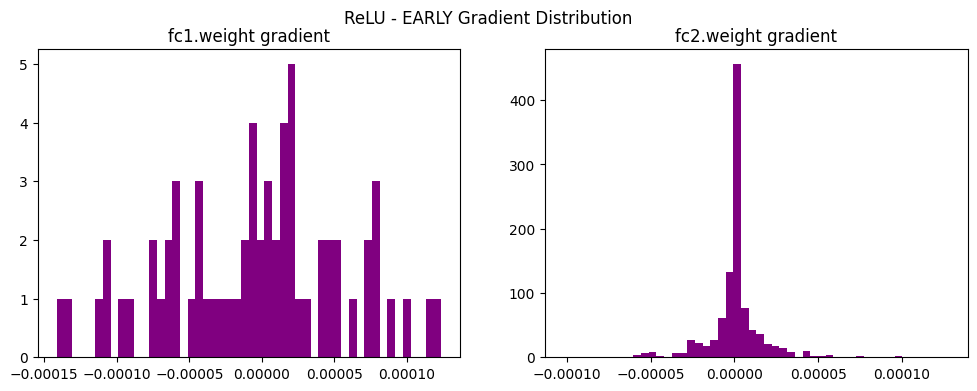

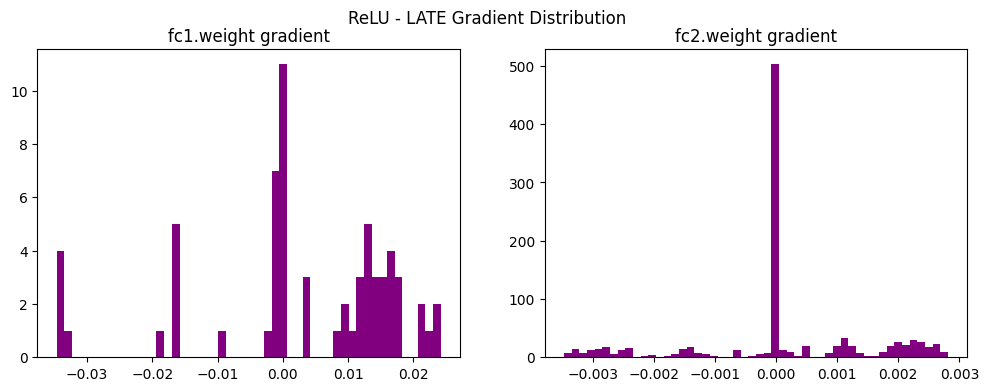

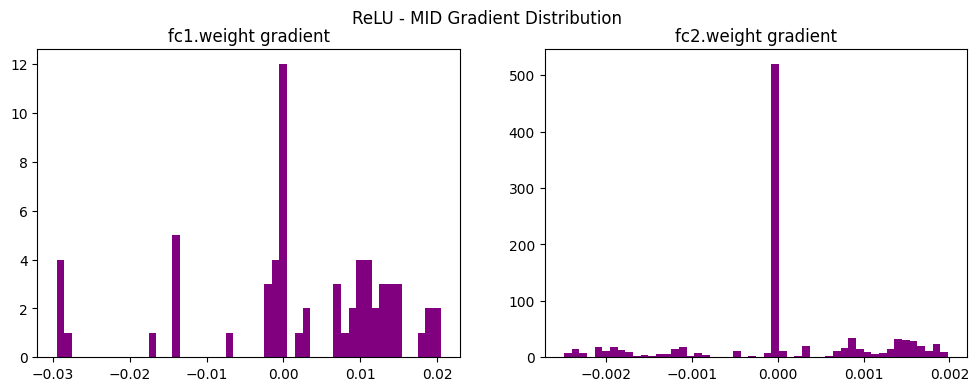

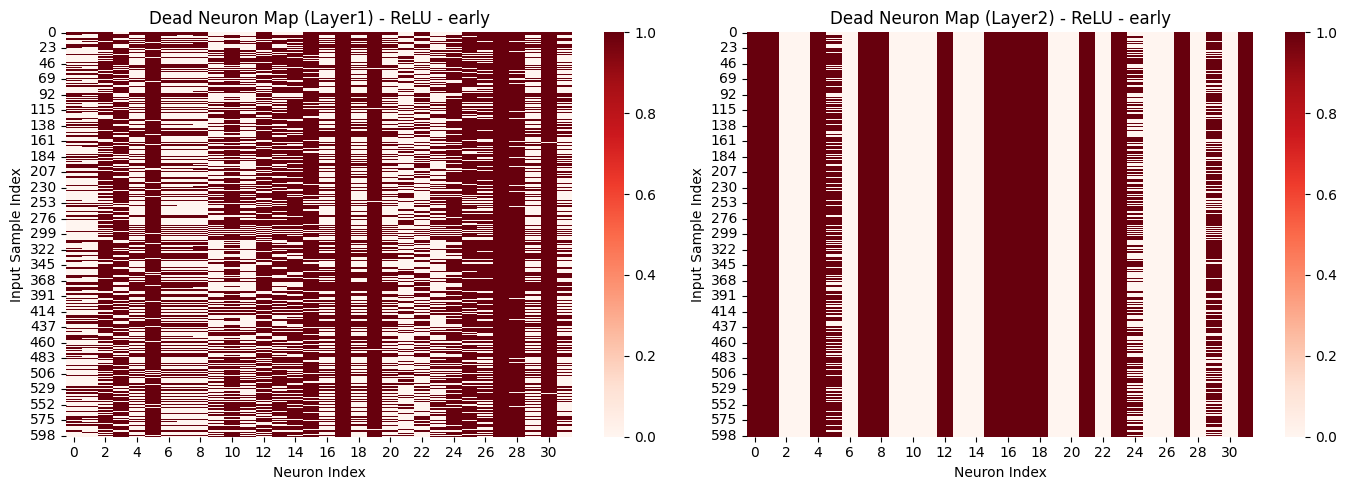

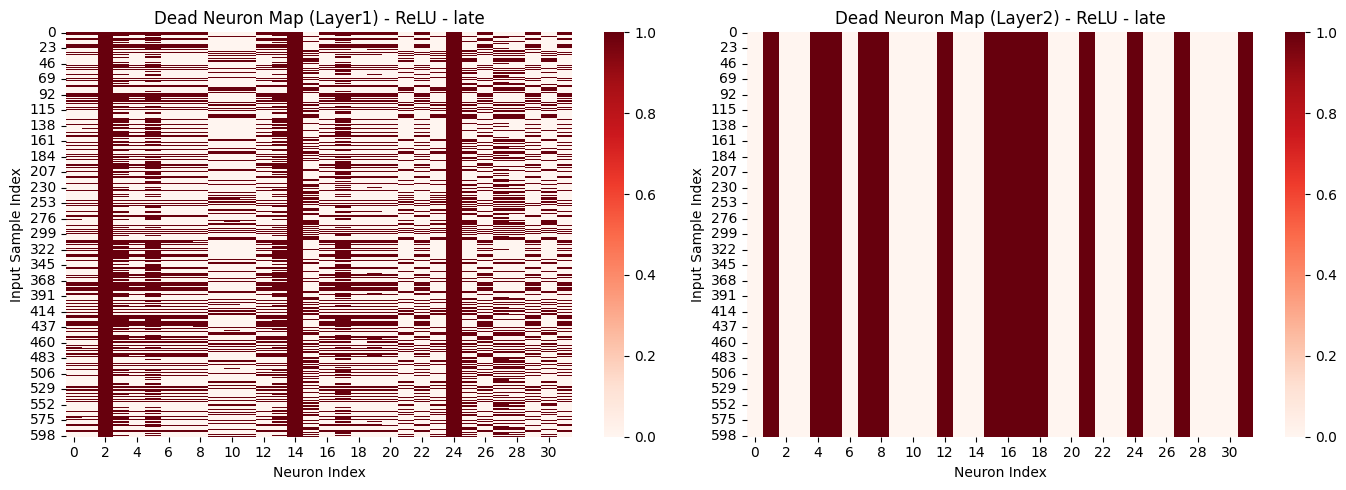

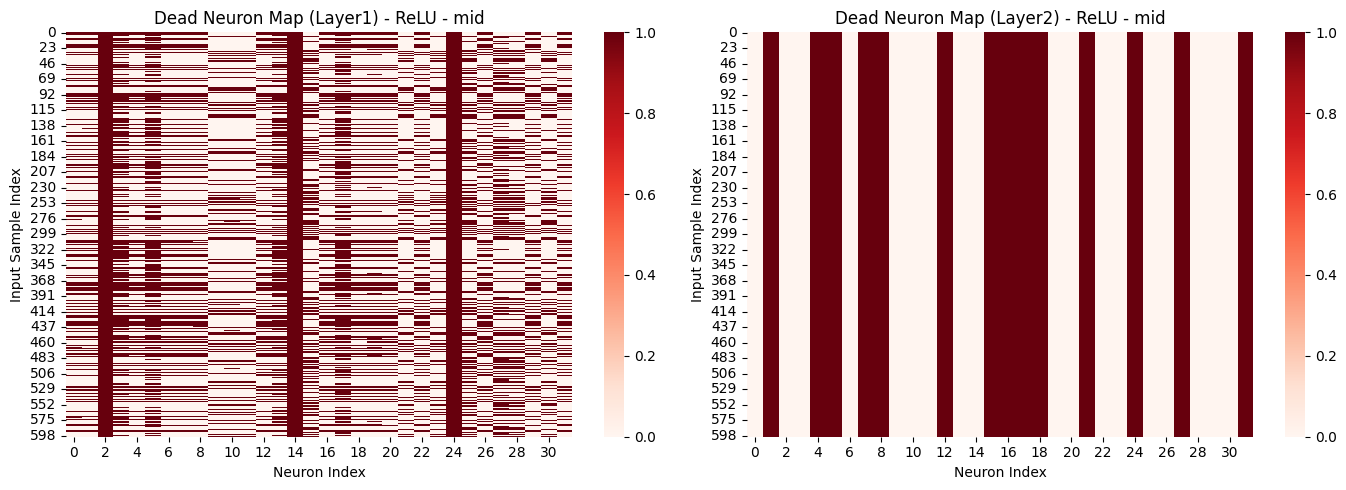

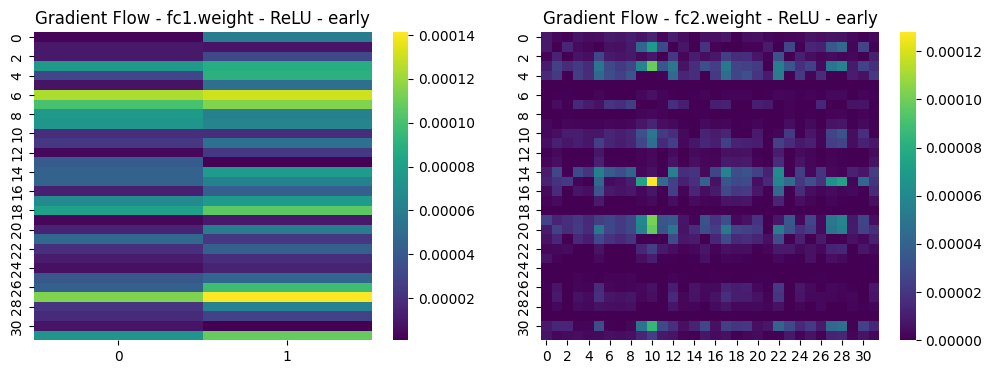

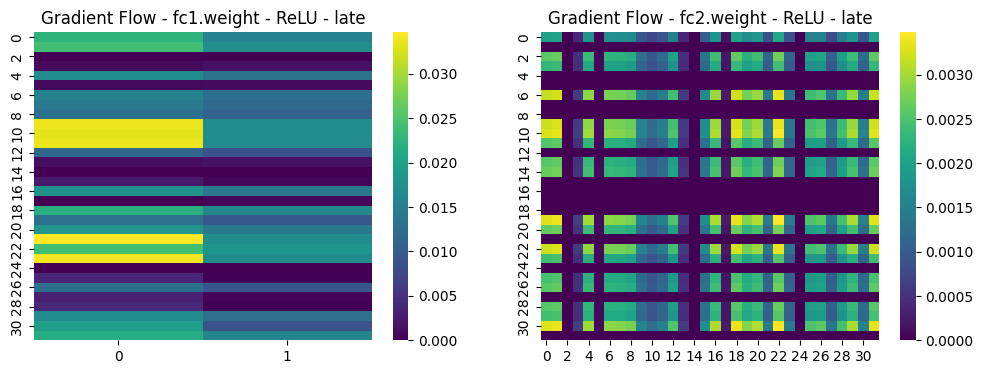

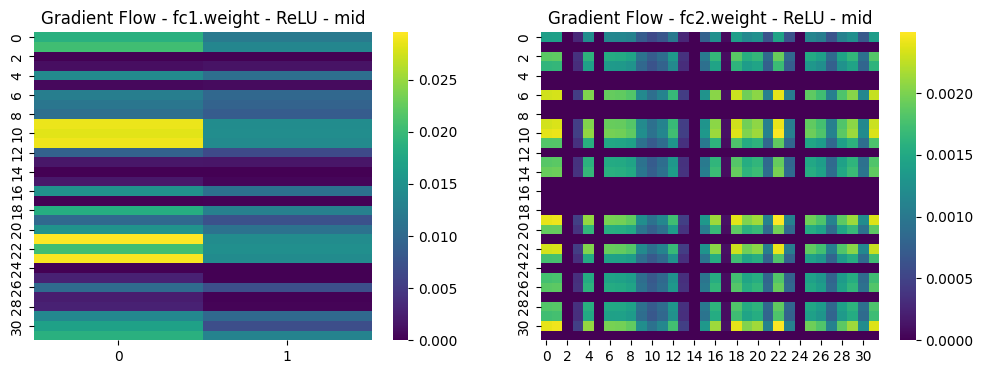

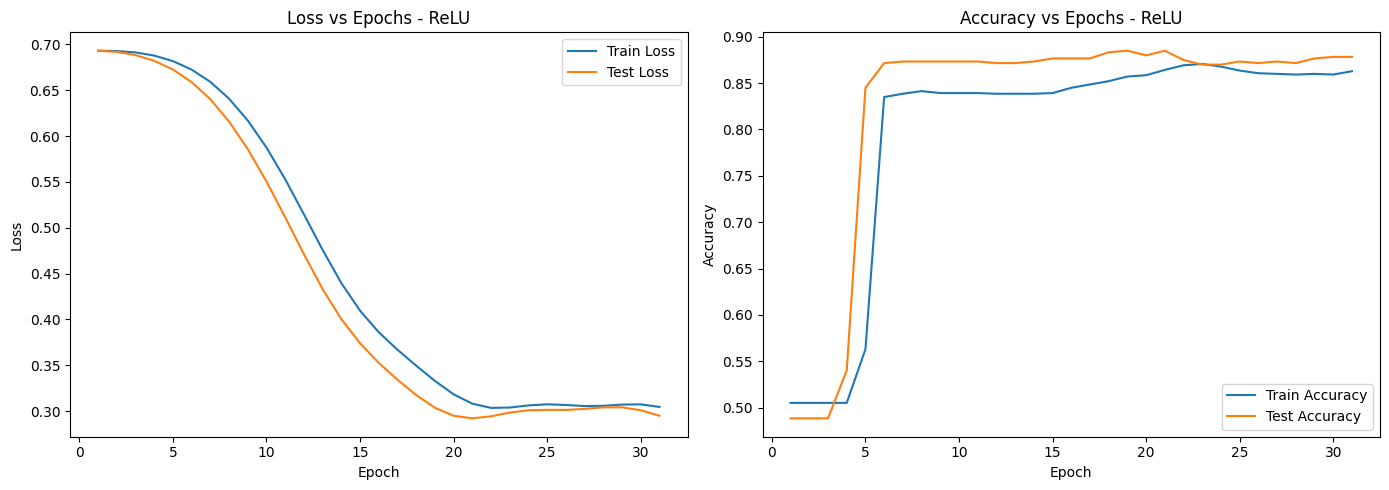

[ReLU] Dead Neuron Ratio (후반 평균): 42.20% (Layer1: 40.65%, Layer2: 43.75%)

==== LeakyReLU 활성화 함수 실험 ====
Epoch 01 | Train Loss: 0.6931, Train Acc: 0.5050 | Test Loss: 0.6931, Test Acc: 0.4883
Epoch 02 | Train Loss: 0.6928, Train Acc: 0.5050 | Test Loss: 0.6917, Test Acc: 0.4883
Epoch 03 | Train Loss: 0.6911, Train Acc: 0.5050 | Test Loss: 0.6878, Test Acc: 0.4883
Epoch 04 | Train Loss: 0.6872, Train Acc: 0.5050 | Test Loss: 0.6802, Test Acc: 0.7183
Epoch 05 | Train Loss: 0.6798, Train Acc: 0.7257 | Test Loss: 0.6673, Test Acc: 0.8533
Epoch 06 | Train Loss: 0.6673, Train Acc: 0.8386 | Test Loss: 0.6473, Test Acc: 0.8717
Epoch 07 | Train Loss: 0.6477, Train Acc: 0.8386 | Test Loss: 0.6183, Test Acc: 0.8733
Epoch 08 | Train Loss: 0.6194, Train Acc: 0.8407 | Test Loss: 0.5797, Test Acc: 0.8717
Epoch 09 | Train Loss: 0.5817, Train Acc: 0.8443 | Test Loss: 0.5320, Test Acc: 0.8700
Epoch 10 | Train Loss: 0.5354, Train Acc: 0.8429 | Test Loss: 0.4780, Test Acc: 0.8700
Epoch 11 | Train Loss: 0.

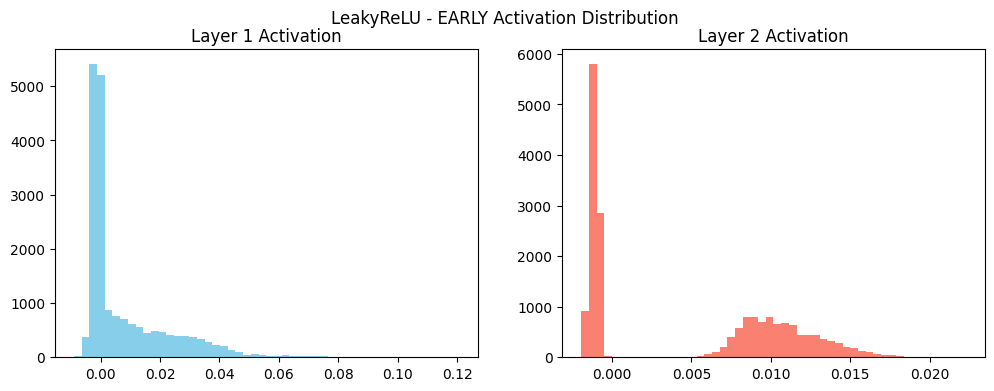

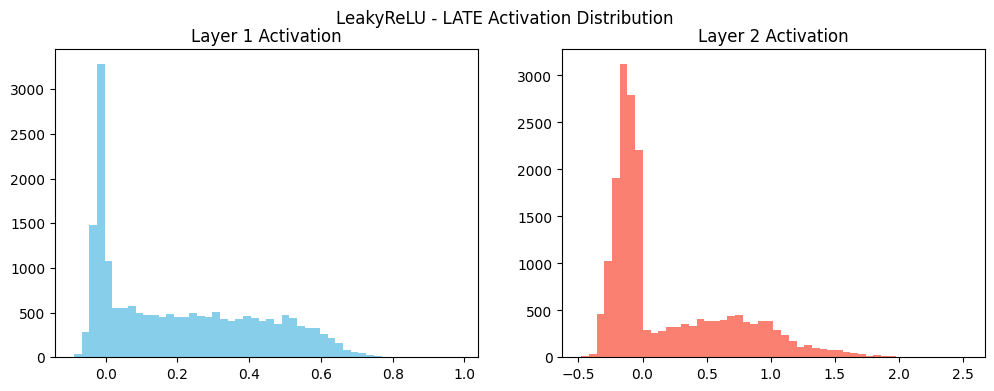

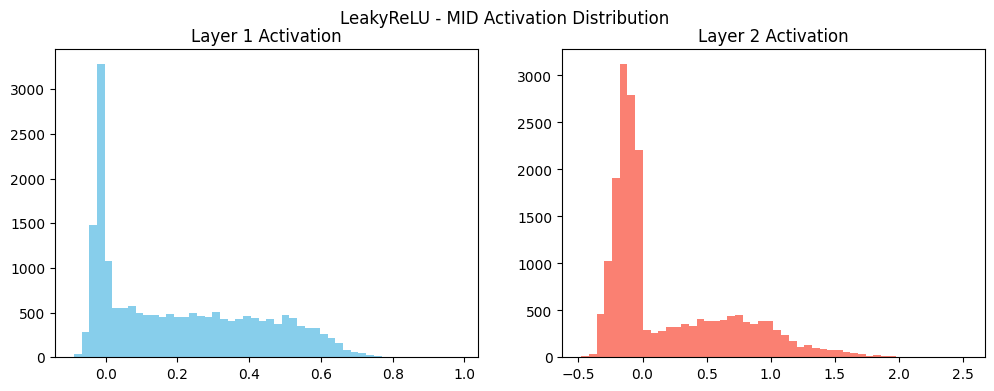

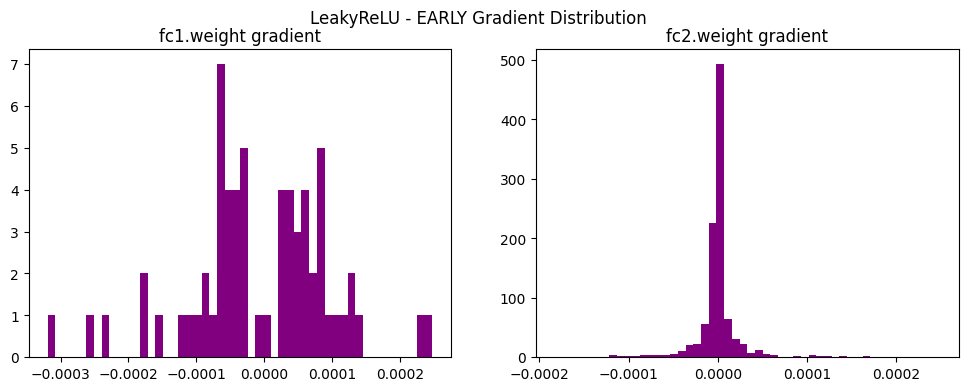

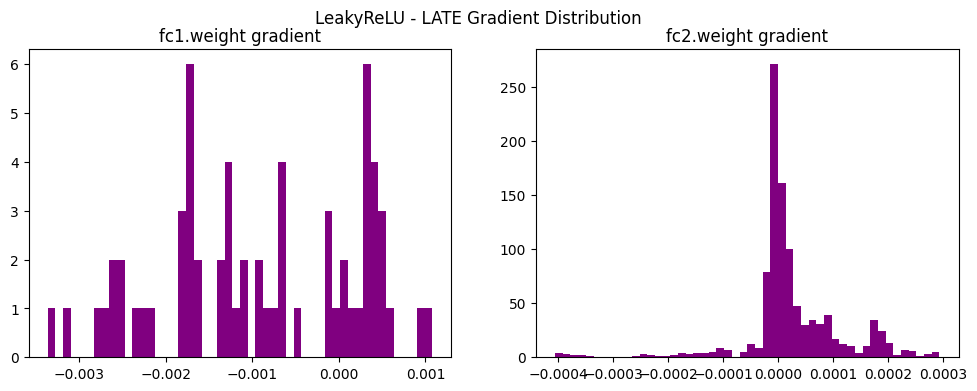

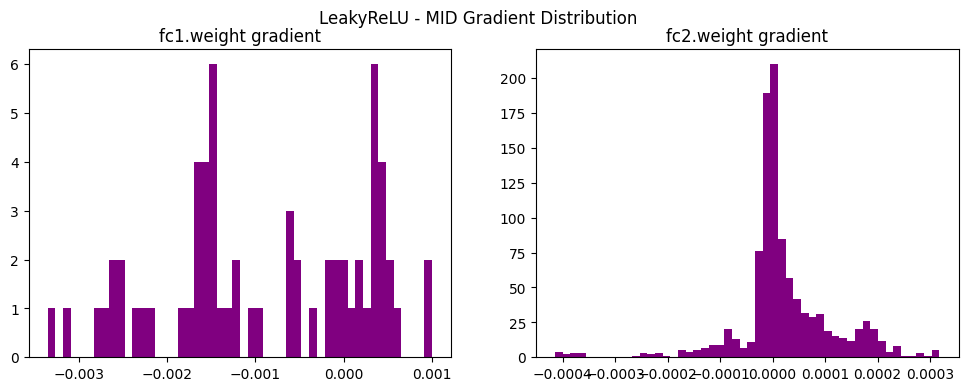

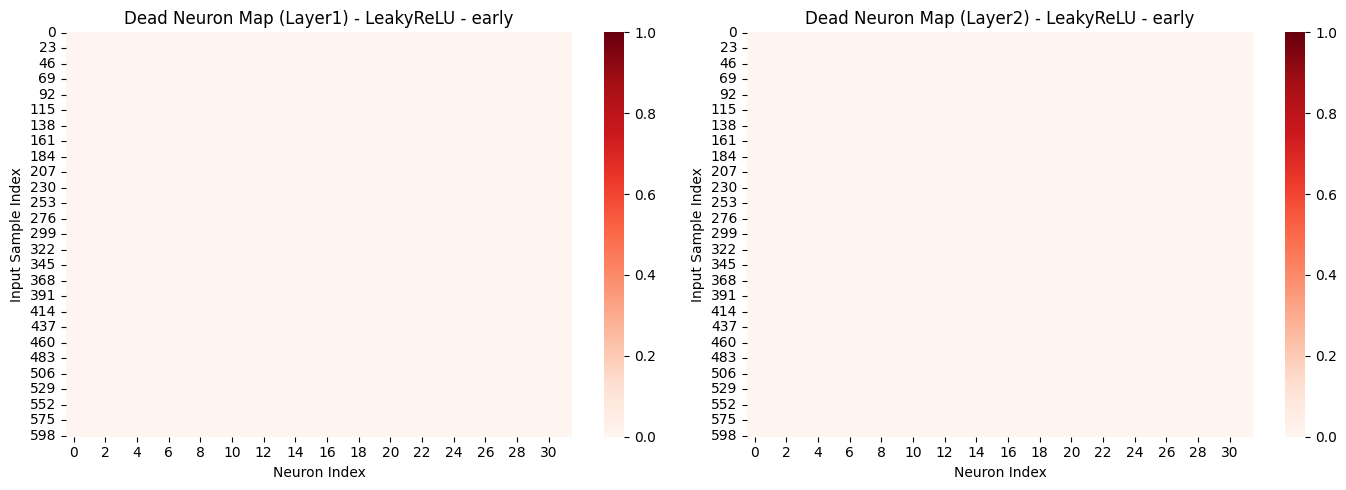

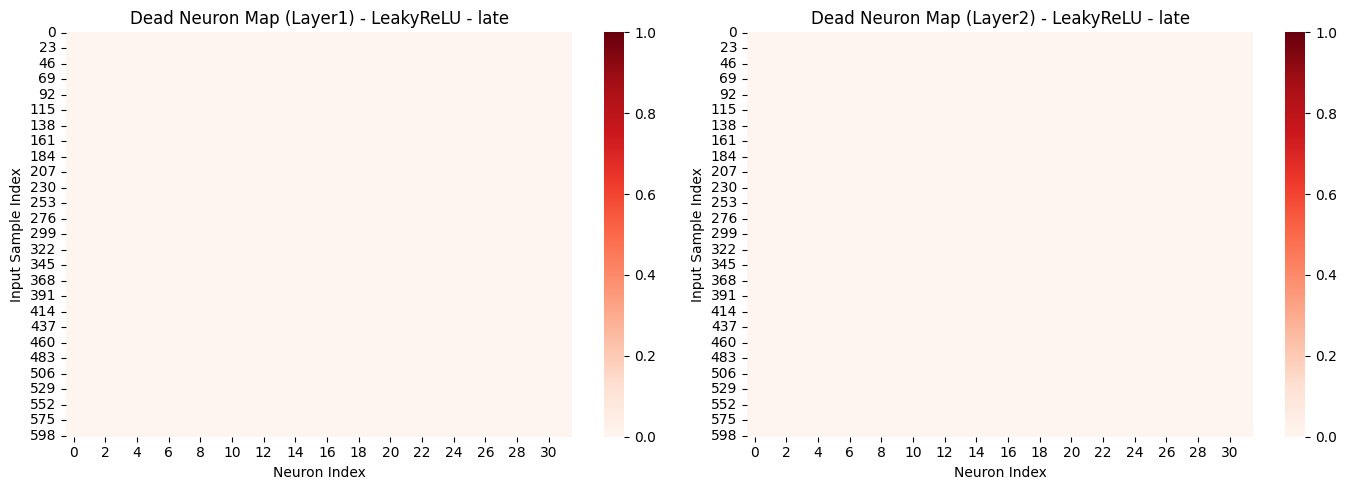

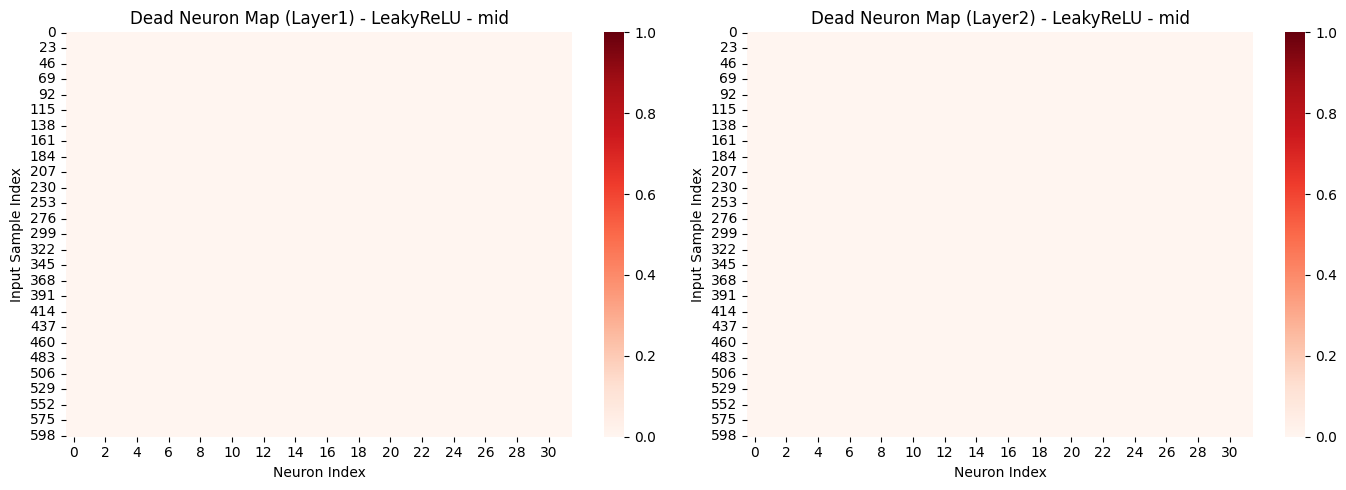

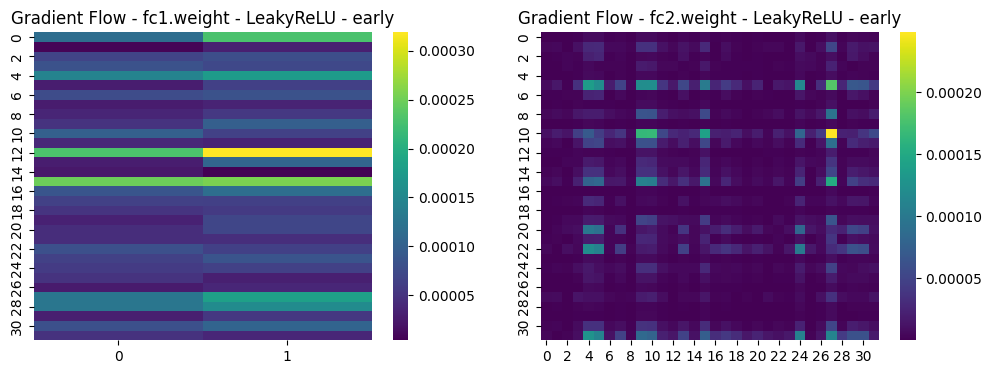

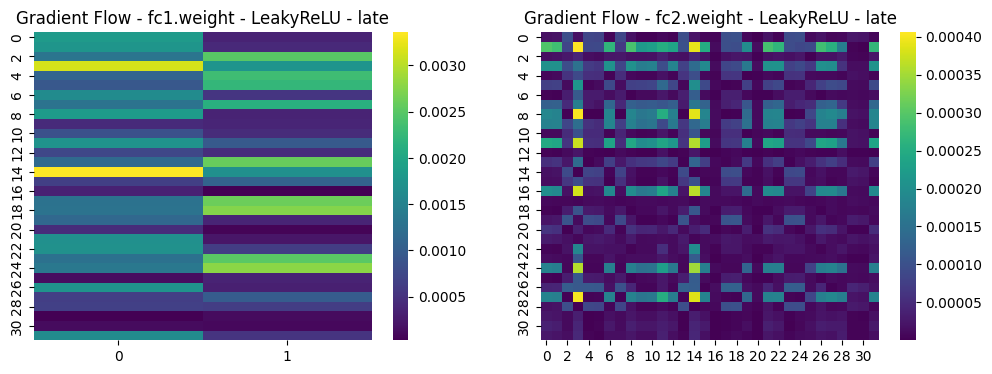

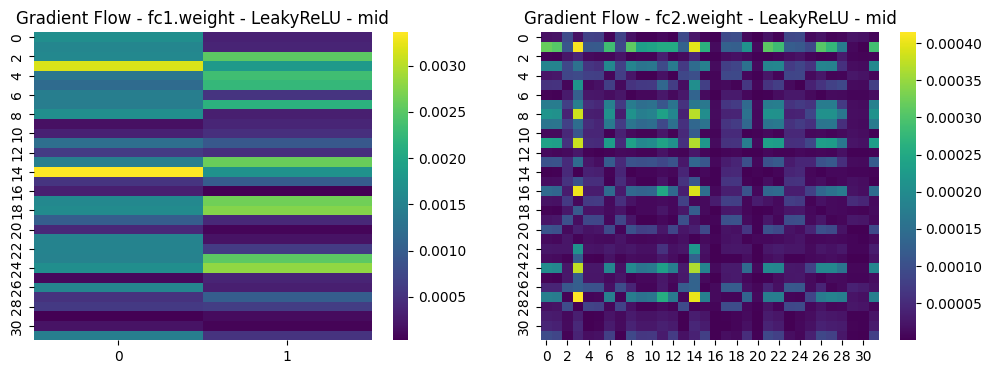

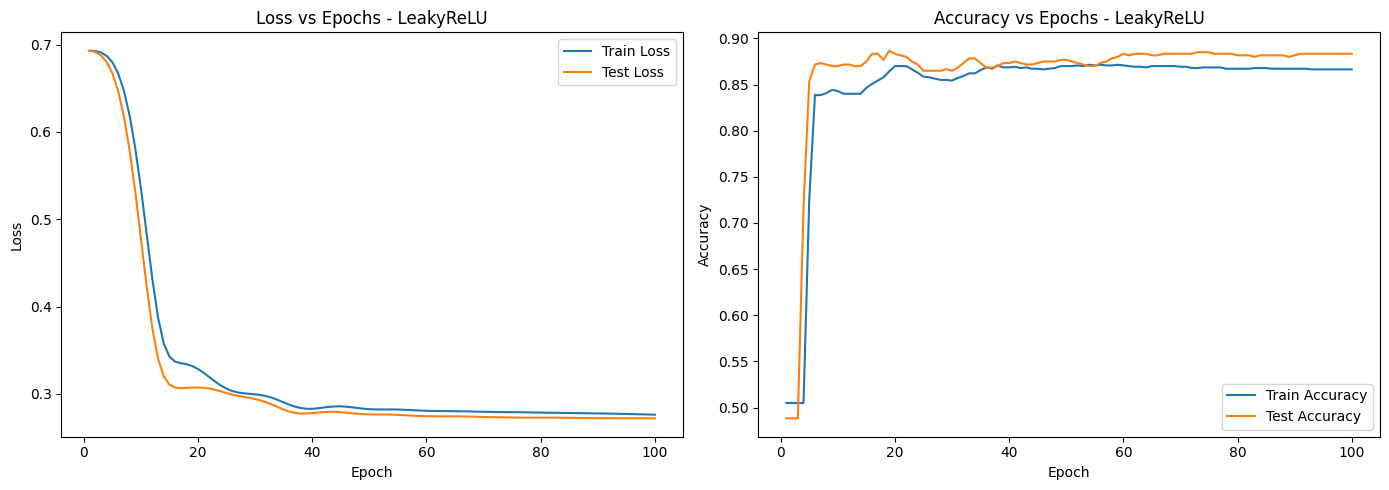

[LeakyReLU] Dead Neuron Ratio (후반 평균): 0.00% (Layer1: 0.00%, Layer2: 0.00%)

==== Sigmoid 활성화 함수 실험 ====
Epoch 01 | Train Loss: 0.6949, Train Acc: 0.4950 | Test Loss: 0.7037, Test Acc: 0.4883
Epoch 02 | Train Loss: 0.6995, Train Acc: 0.5050 | Test Loss: 0.6968, Test Acc: 0.4883
Epoch 03 | Train Loss: 0.6946, Train Acc: 0.5050 | Test Loss: 0.6929, Test Acc: 0.5117
Epoch 04 | Train Loss: 0.6932, Train Acc: 0.4950 | Test Loss: 0.6932, Test Acc: 0.5117
Epoch 05 | Train Loss: 0.6950, Train Acc: 0.4950 | Test Loss: 0.6931, Test Acc: 0.5117
Epoch 06 | Train Loss: 0.6951, Train Acc: 0.4950 | Test Loss: 0.6925, Test Acc: 0.5117
Epoch 07 | Train Loss: 0.6938, Train Acc: 0.4950 | Test Loss: 0.6926, Test Acc: 0.5117
Epoch 08 | Train Loss: 0.6928, Train Acc: 0.4950 | Test Loss: 0.6935, Test Acc: 0.4883
Epoch 09 | Train Loss: 0.6928, Train Acc: 0.5050 | Test Loss: 0.6944, Test Acc: 0.4883
Epoch 10 | Train Loss: 0.6932, Train Acc: 0.5050 | Test Loss: 0.6947, Test Acc: 0.4883
Epoch 11 | Train Loss: 0.

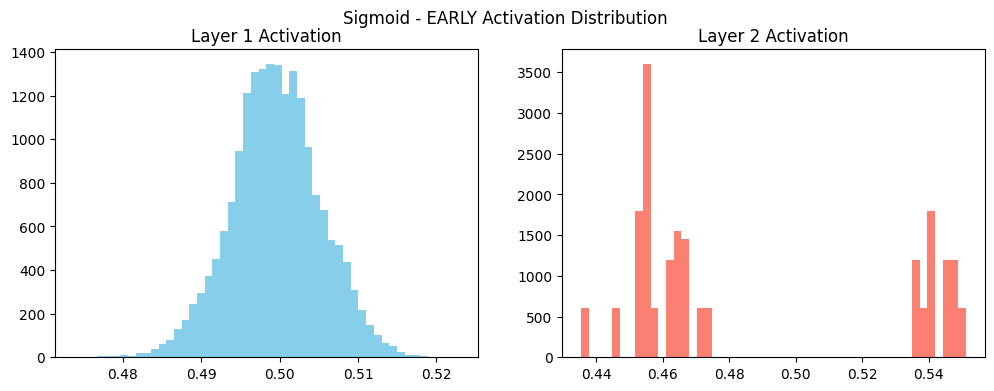

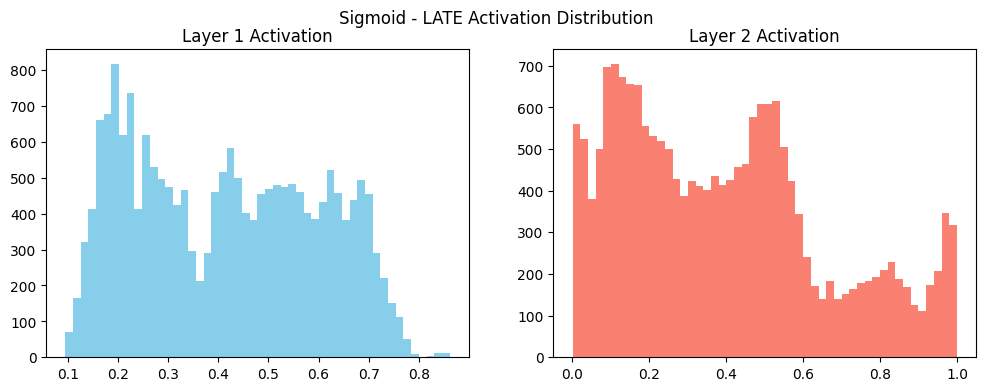

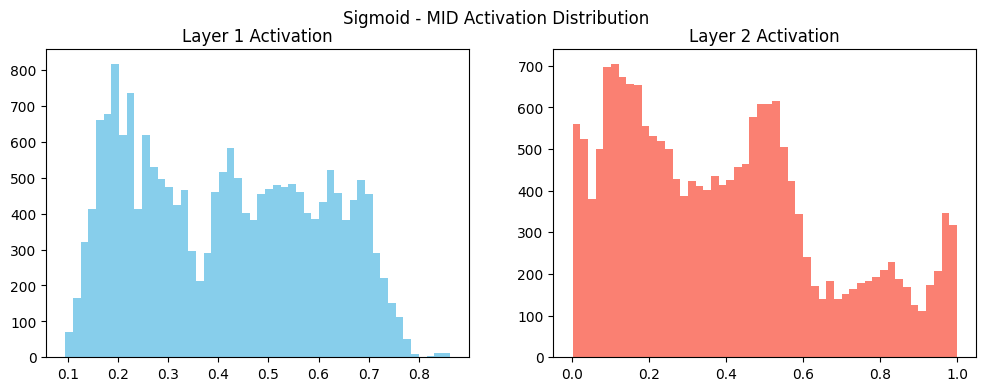

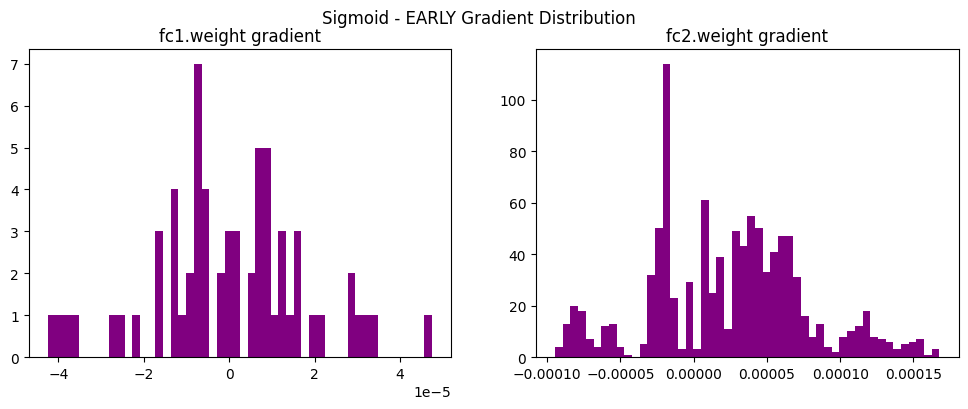

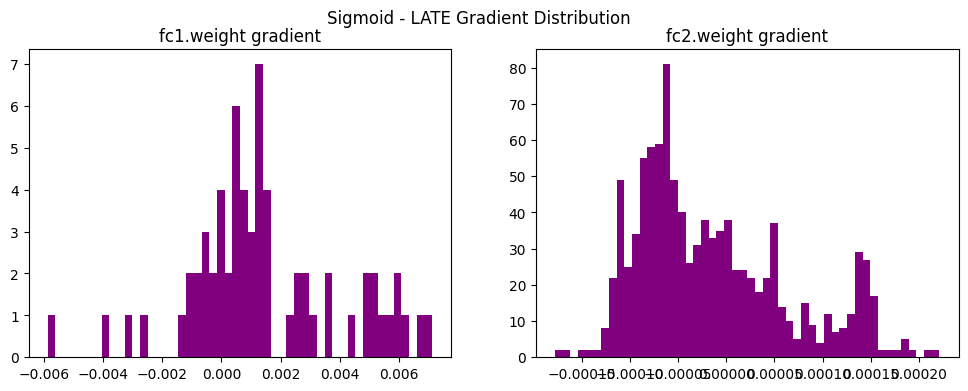

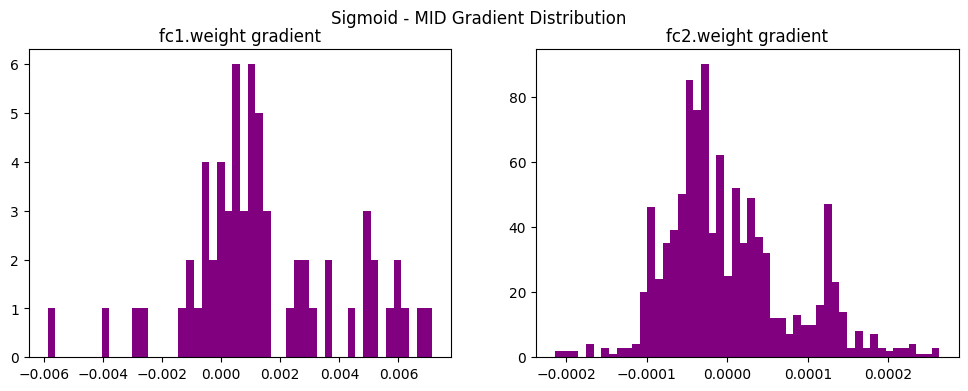

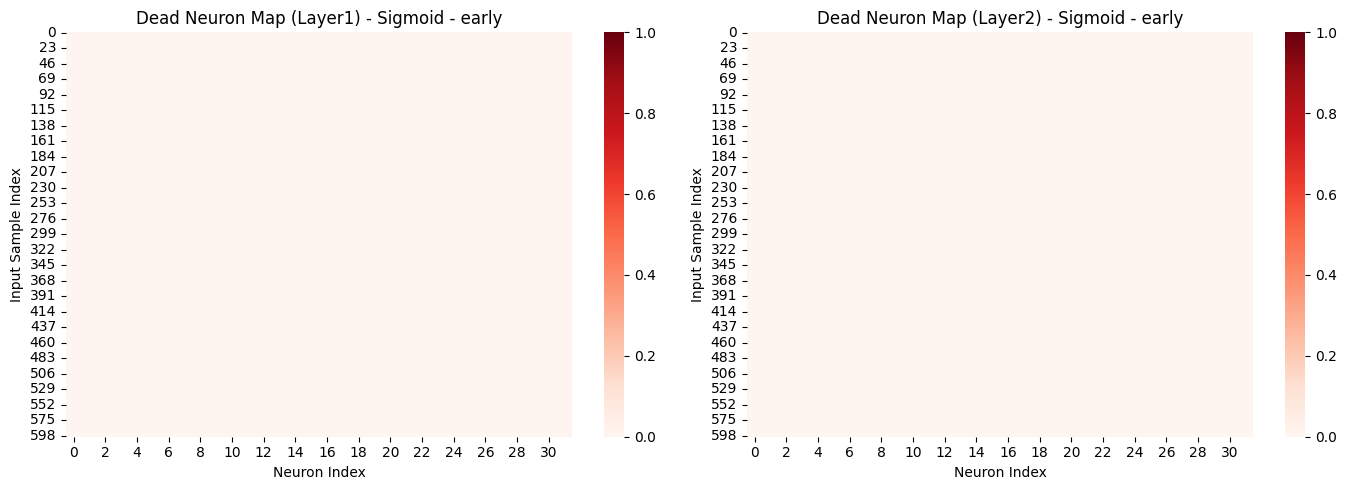

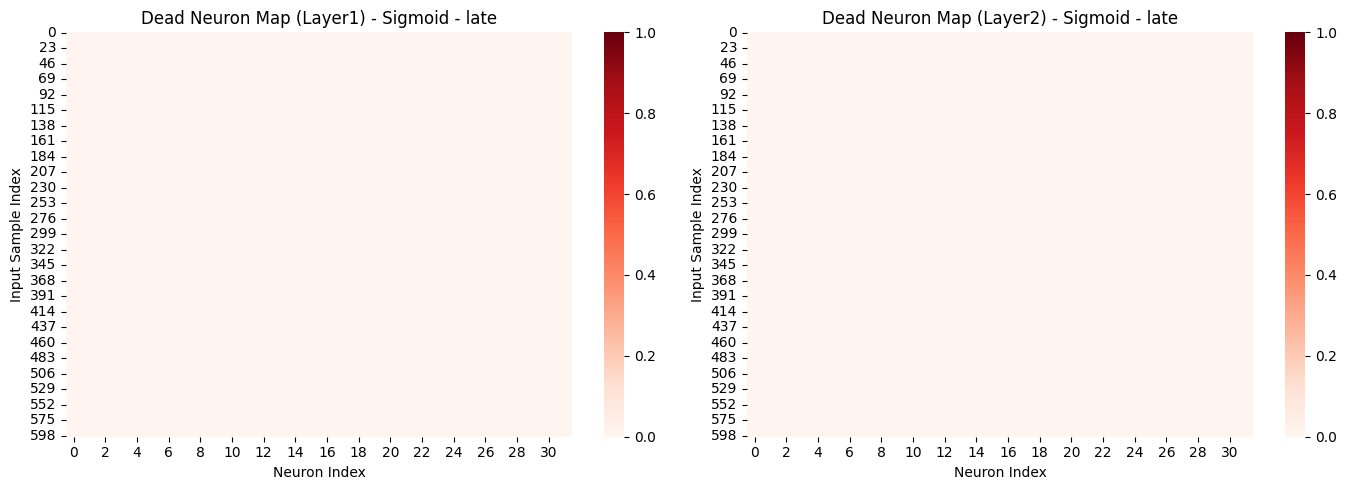

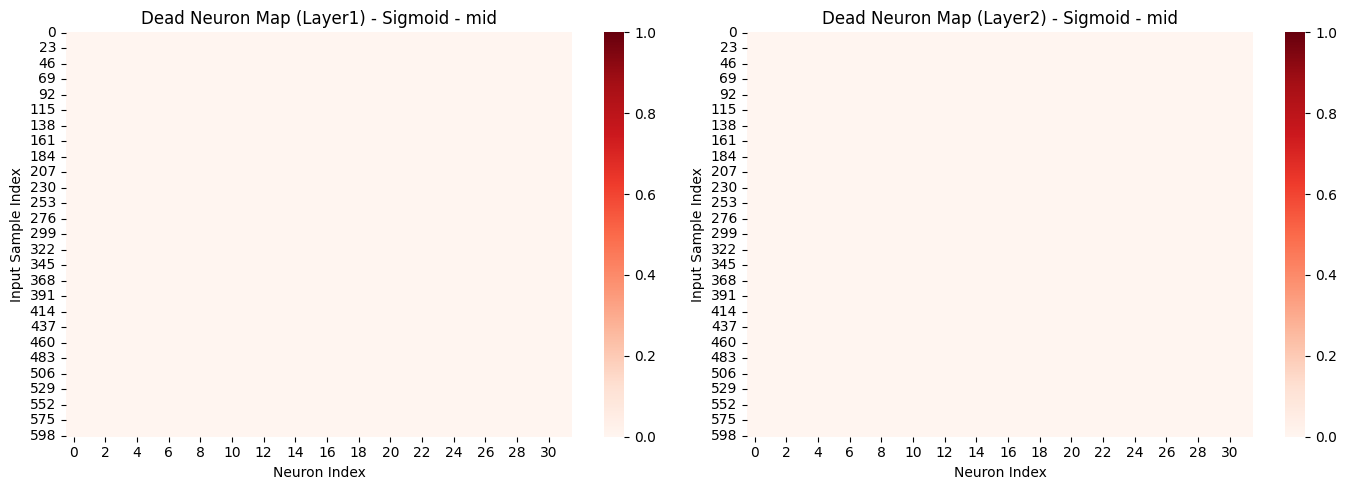

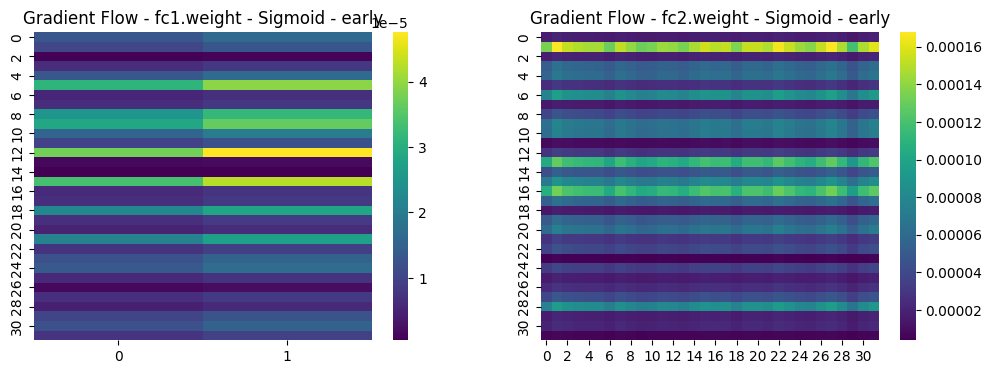

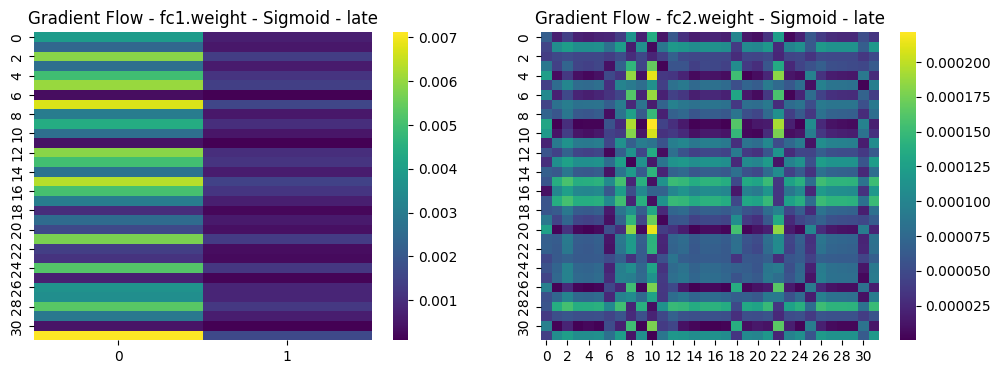

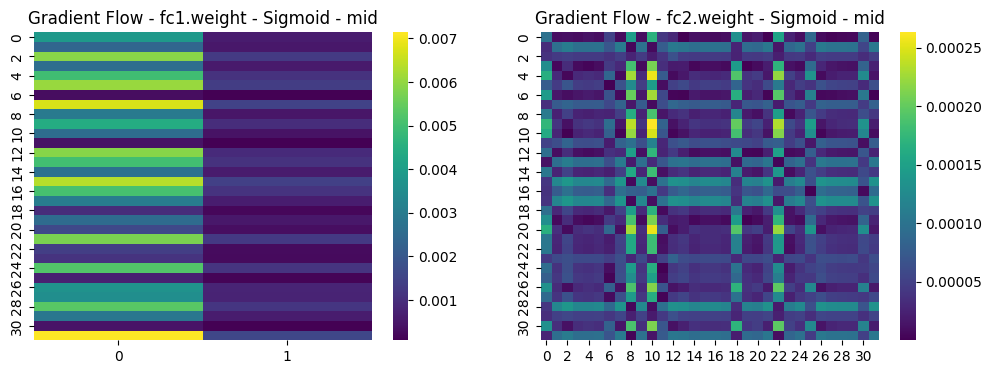

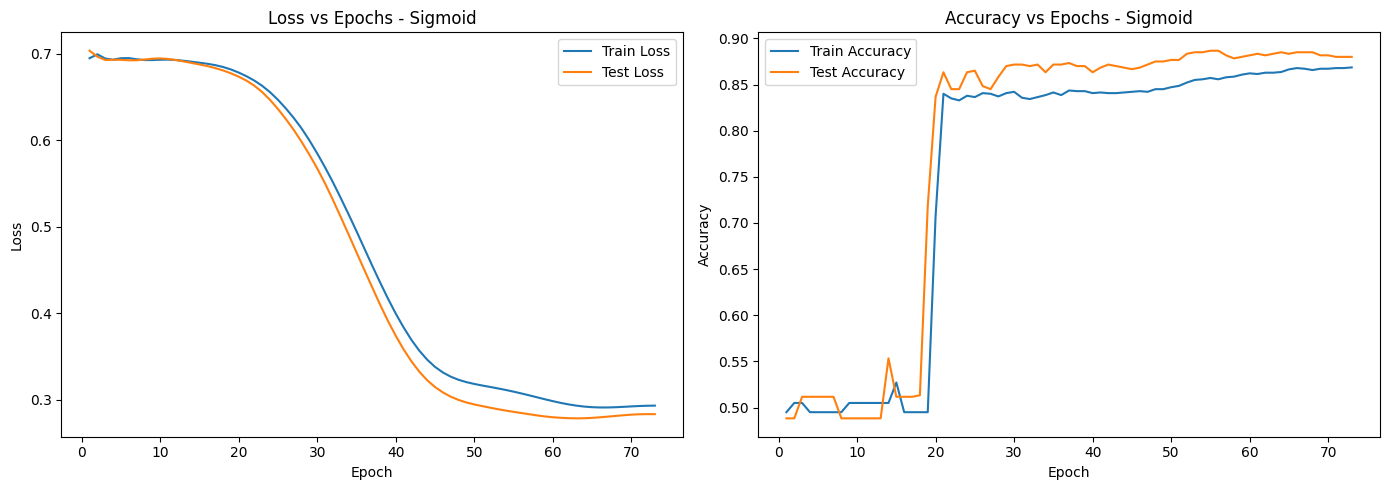

[Sigmoid] Dead Neuron Ratio (후반 평균): 0.00% (Layer1: 0.00%, Layer2: 0.00%)

===== 요약 테이블 =====
활성화 함수	Dead ReLU 비율(%)	최종 정확도(%)
ReLU		42.20052063			87.83333302
LeakyReLU		0.00000000			88.33333254
Sigmoid		0.00000000			87.99999952


In [3]:
# 기본 설정
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#시드고정
set_seed(42)

# 데이터셋 생성 함수
def get_dataset(name="moons"):
    if name == "moons":
        X, y = make_moons(n_samples=2000, noise=0.2)
    elif name == "circles":
        X, y = make_circles(n_samples=2000, noise=0.2, factor=0.5)
    else:
        raise ValueError("Unsupported dataset")

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long), \
           torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

#모델 정의
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.activation = activation_fn
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        z1 = self.fc1(x)
        a1 = self.activation(z1)
        z2 = self.fc2(a1)
        a2 = self.activation(z2)
        out = self.fc3(a2)
        return out, [z1, a1, z2, a2]

# 학습 함수 (Early Stopping, Activation & Gradient 저장)
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, early_stopping_patience=10):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    act_store = {}
    grad_store = {}
    final_epoch = 0

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        outputs, _ = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()

        if epoch == 1:
            grad_store["early"] = {name: param.grad.detach().cpu().clone() for name, param in model.named_parameters() if param.grad is not None}

        optimizer.step()

        preds = outputs.argmax(dim=1)
        acc = (preds == y_train).float().mean().item()

        model.eval()
        with torch.no_grad():
            test_outputs, test_acts = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            test_preds = test_outputs.argmax(dim=1)
            test_acc = (test_preds == y_test).float().mean().item()

        print(f"Epoch {epoch:02d} | Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        train_losses.append(loss.item())
        test_losses.append(test_loss)
        train_accs.append(acc)
        test_accs.append(test_acc)

        if epoch == 1:
            act_store["early"] = [test_acts[1].detach().cpu(), test_acts[3].detach().cpu()]

        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            final_epoch = epoch
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch:02d}")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 후반
    model.eval()
    with torch.no_grad():
        _, acts = model(X_test)
        act_store["late"] = [acts[1].detach().cpu(), acts[3].detach().cpu()]
    grad_store["late"] = {name: param.grad.detach().cpu().clone() for name, param in model.named_parameters() if param.grad is not None}

    # 중반
    mid_epoch = max(1, final_epoch // 2)
    temp_model = MLP(model.activation).to(device)
    temp_model.load_state_dict(best_model_state)
    temp_model.train()
    temp_model.zero_grad()
    mid_outputs, _ = temp_model(X_train)
    mid_loss = criterion(mid_outputs, y_train)
    mid_loss.backward()

    grad_store["mid"] = {name: param.grad.detach().cpu().clone() for name, param in temp_model.named_parameters() if param.grad is not None}
    temp_model.eval()
    with torch.no_grad():
        _, mid_acts = temp_model(X_test)
        act_store["mid"] = [mid_acts[1].detach().cpu(), mid_acts[3].detach().cpu()]

    return model, act_store, grad_store, test_acc, train_losses, train_accs, test_losses, test_accs

#활성화 히스토그램

def plot_activation_histograms(saved_acts_dict, act_name):
    for key, (a1, a2) in saved_acts_dict.items():
        a1 = a1.numpy().flatten()
        a2 = a2.numpy().flatten()

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{act_name} - {key.upper()} Activation Distribution")

        plt.subplot(1, 2, 1)
        plt.hist(a1, bins=50, color='skyblue')
        plt.title("Layer 1 Activation")

        plt.subplot(1, 2, 2)
        plt.hist(a2, bins=50, color='salmon')
        plt.title("Layer 2 Activation")

        plt.show()

#Gradient 히스토그램

def plot_gradient_histograms(grad_dict, act_name):
    for phase, grads in grad_dict.items():
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{act_name} - {phase.upper()} Gradient Distribution")

        for i, layer_name in enumerate(["fc1.weight", "fc2.weight"]):
            if layer_name in grads:
                grad_vals = grads[layer_name].flatten().numpy()
                plt.subplot(1, 2, i + 1)
                plt.hist(grad_vals, bins=50, color='purple')
                plt.title(f"{layer_name} gradient")
        plt.show()

# 히트맵 시각화 함수 (Dead Neuron & Gradient 소멸 위치)
def plot_dead_neuron_heatmap(activations, act_name):
    for key, (a1, a2) in activations.items():
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.heatmap(np.mean(a1.numpy() == 0, axis=0)[None, :], ax=axes[0], cmap='Reds')
        axes[0].set_title(f"Dead Neuron Ratio (Layer1) - {act_name} - {key}")
        sns.heatmap(np.mean(a2.numpy() == 0, axis=0)[None, :], ax=axes[1], cmap='Reds')
        axes[1].set_title(f"Dead Neuron Ratio (Layer2) - {act_name} - {key}")
        plt.show()

def plot_gradient_heatmap(grads, act_name):
    for key, grad_dict in grads.items():
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        for i, layer in enumerate(["fc1.weight", "fc2.weight"]):
            grad = grad_dict[layer].numpy()
            sns.heatmap(np.abs(grad), ax=axes[i], cmap='viridis')
            axes[i].set_title(f"Gradient Flow - {layer} - {act_name} - {key}")
        plt.show()



#Dead ReLU 비율 계산 함수
def compute_dead_relu_ratio(saved_acts_dict, act_name):
    # 후반 시점 기준으로 계산
    if "late" in saved_acts_dict:
        a1, a2 = saved_acts_dict["late"]
    else:
        a1, a2 = list(saved_acts_dict.values())[-1]  # 마지막 시점

    # 비활성 기준 설정 (ReLU: == 0, 그 외: < 1e-4)
    if 'ReLU' in act_name:
        dead1 = (a1 == 0).float().mean().item() * 100
        dead2 = (a2 == 0).float().mean().item() * 100
    else:
        dead1 = (a1.abs() < 1e-4).float().mean().item() * 100
        dead2 = (a2.abs() < 1e-4).float().mean().item() * 100

    avg_dead = (dead1 + dead2) / 2
    print(f"[{act_name}] Dead Neuron Ratio (후반 평균): {avg_dead:.2f}% (Layer1: {dead1:.2f}%, Layer2: {dead2:.2f}%)")
    return avg_dead

# Dead ReLU 히트맵 시각화 함수 (기준 완화 적용)
def plot_dead_neuron_heatmap(activations, act_name):
    for key, (a1, a2) in activations.items():
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        for idx, (a, layer_name) in enumerate(zip([a1, a2], ["Layer1", "Layer2"])):
            a = a.numpy()
            if 'ReLU' in act_name:
                dead_map = (a == 0).astype(float)
            else:
                dead_map = (np.abs(a) < 1e-4).astype(float)

            sns.heatmap(dead_map, ax=axes[idx], cmap='Reds', cbar=True, vmin=0, vmax=1)
            axes[idx].set_title(f"Dead Neuron Map ({layer_name}) - {act_name} - {key}")
            axes[idx].set_xlabel("Neuron Index")
            axes[idx].set_ylabel("Input Sample Index")
        plt.tight_layout()
        plt.show()

# 손실 및 정확도 곡선 시각화 함수
def plot_loss_accuracy_curves(train_losses, train_accs, test_losses, test_accs, act_name):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title(f"Loss vs Epochs - {act_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, test_accs, label='Test Accuracy')
    plt.title(f"Accuracy vs Epochs - {act_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

#  실행
activations = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(0.1),
    'Sigmoid': nn.Sigmoid()
}

dataset = "moons"
X_train, y_train, X_test, y_test = get_dataset(dataset)

summary_table = []

for name, act_fn in activations.items():
    print(f"\n==== {name} 활성화 함수 실험 ====")
    model = MLP(act_fn)
    trained_model, saved_acts_dict, grad_dict, acc, train_losses, train_accs, test_losses, test_accs = train_model(model, X_train, y_train, X_test, y_test)
    print(f"Test Accuracy: {acc:.4f}")
    plot_activation_histograms(saved_acts_dict, name)
    plot_gradient_histograms(grad_dict, name)
    plot_dead_neuron_heatmap(saved_acts_dict, name)
    plot_gradient_heatmap(grad_dict, name)
    plot_loss_accuracy_curves(train_losses, train_accs, test_losses, test_accs, name)

    dead_ratio = compute_dead_relu_ratio(saved_acts_dict, name)
    summary_table.append((name, dead_ratio, acc))

print("\n===== 요약 테이블 =====")
print("활성화 함수\tDead ReLU 비율(%)\t최종 정확도(%)")
for name, dead_ratio, acc in summary_table:
    print(f"{name}\t\t{dead_ratio:.8f}\t\t\t{acc * 100:.8f}")



#실험 C

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 0. Seed 고정
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# 1. 하이퍼파라미터 설정
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATES = [0.1, 0.01, 0.001]
PATIENCE = 5  # Early Stopping

# 2. 데이터셋
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 3. 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

# 4. 평가 함수
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            output = model(x)
            pred = output.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# 5. 수렴 안정성 판단
def classify_stability(loss_list):
    delta = max(loss_list) - min(loss_list)
    if delta < 0.3:
        return "매우 안정적"
    elif delta < 0.6:
        return "안정적"
    else:
        return "불안정"

# 6. Gradient 평균 추적
def get_gradient_stats(model):
    grad_means = []
    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            grad_means.append(param.grad.abs().mean().item())
    return grad_means

# 7. 학습 함수 (Early Stopping 포함)
def train_model(optimizer_name, lr, patience=PATIENCE):
    model = MLP()
    loss_fn = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Momentum':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    train_losses, test_accuracies, grad_history = [], [], []

    best_acc = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            grad_stats = get_gradient_stats(model)
            grad_history.append(grad_stats)
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        acc = evaluate(model, test_loader)
        test_accuracies.append(acc)
        scheduler.step()

        print(f"{optimizer_name} (lr={lr}) Epoch {epoch+1} - Loss: {train_losses[-1]:.4f}, Acc: {acc:.4f}")

        # Early Stopping
        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, test_accuracies, grad_history

# 8. 실험 실행
results = {}
summary_data = []
gradient_data = {}

for opt in ['SGD', 'Momentum', 'Adam']:
    for lr in LEARNING_RATES:
        key = f'{opt}_lr{lr}'
        print(f"\n=== Training with {key} ===")
        losses, accs, grads = train_model(opt, lr)
        results[key] = {'loss': losses, 'acc': accs}
        gradient_data[key] = grads
        final_acc = round(accs[-1] * 100, 2)
        min_loss_epoch = np.argmin(losses) + 1
        stability = classify_stability(losses)
        summary_data.append([key, final_acc, min_loss_epoch, stability])

# 9. 결과 시각화
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for key in results:
    plt.plot(results[key]['loss'], label=f"{key}")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for key in results:
    plt.plot(results[key]['acc'], label=f"{key}")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# 10. Gradient 흐름 시각화
for key in gradient_data:
    grads = np.array(gradient_data[key])
    plt.figure(figsize=(8, 4))
    for i in range(grads.shape[1]):
        plt.plot(grads[:, i], label=f'Layer {i+1}')
    plt.title(f"Gradient Flow per Layer - {key}")
    plt.xlabel("Step")
    plt.ylabel("Mean |Gradient|")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 11. 요약 테이블 출력
summary_df = pd.DataFrame(summary_data, columns=["Optimizer", "최종 정확도 (%)", "수렴 속도 (epoch)", "수렴 안정성"])
print("\nOptimizer 성능 요약표:")
print(summary_df.to_string(index=False))



=== Training with SGD_lr0.1 ===
SGD (lr=0.1) Epoch 1 - Loss: 0.6223, Acc: 0.8126
SGD (lr=0.1) Epoch 2 - Loss: 0.4007, Acc: 0.8465
SGD (lr=0.1) Epoch 3 - Loss: 0.3499, Acc: 0.8377
SGD (lr=0.1) Epoch 4 - Loss: 0.3207, Acc: 0.8680
SGD (lr=0.1) Epoch 5 - Loss: 0.2960, Acc: 0.8711
SGD (lr=0.1) Epoch 6 - Loss: 0.2770, Acc: 0.8727
SGD (lr=0.1) Epoch 7 - Loss: 0.2588, Acc: 0.8738
SGD (lr=0.1) Epoch 8 - Loss: 0.2445, Acc: 0.8798
SGD (lr=0.1) Epoch 9 - Loss: 0.2309, Acc: 0.8794
SGD (lr=0.1) Epoch 10 - Loss: 0.2185, Acc: 0.8852
SGD (lr=0.1) Epoch 11 - Loss: 0.2071, Acc: 0.8858
SGD (lr=0.1) Epoch 12 - Loss: 0.1960, Acc: 0.8847
SGD (lr=0.1) Epoch 13 - Loss: 0.1862, Acc: 0.8686
SGD (lr=0.1) Epoch 14 - Loss: 0.1770, Acc: 0.8939
SGD (lr=0.1) Epoch 15 - Loss: 0.1687, Acc: 0.8751
SGD (lr=0.1) Epoch 16 - Loss: 0.1605, Acc: 0.8943
SGD (lr=0.1) Epoch 17 - Loss: 0.1529, Acc: 0.8918
SGD (lr=0.1) Epoch 18 - Loss: 0.1457, Acc: 0.8942
SGD (lr=0.1) Epoch 19 - Loss: 0.1400, Acc: 0.8945
SGD (lr=0.1) Epoch 20 - Lo

KeyboardInterrupt: 